In [2]:
import zipfile

# Download data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

# Unzip the downloaded file
zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip", "r")
zip_ref.extractall()
zip_ref.close()

--2022-05-11 16:49:32--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.16.48, 142.250.186.208, 142.250.75.16, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.16.48|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160,74M  3,21MB/s    in 70s     

2022-05-11 16:50:43 (2,29 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SHAPE = (224, 224)
BATCH_SIZE = 32

train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

# Training images
train_data_10_percent = train_datagen.flow_from_directory(train_dir,
                                               target_size=IMAGE_SHAPE,
                                               batch_size=BATCH_SIZE,
                                               class_mode="categorical")

# Testing images
test_data = train_datagen.flow_from_directory(test_dir,
                                              target_size=IMAGE_SHAPE,
                                              batch_size=BATCH_SIZE,
                                              class_mode="categorical")

Training images:
Found 750 images belonging to 10 classes.
Testing images:
Found 2500 images belonging to 10 classes.


In [4]:
# Create tensorboard callback
import datetime
def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(
      log_dir=log_dir
  )
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback

In [8]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4"

# Original: EfficientNetB0 feature vector (version 1)
efficientnet_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"

In [9]:
def create_model(model_url, num_classes=10):
    # Download the pretrained model and save it as a Keras layer
    feature_extractor_layer = hub.KerasLayer(model_url,
                                            trainable=False, # freeze the underlying patterns
                                            name='feature_extraction_layer',
                                            input_shape=IMAGE_SHAPE+(3,)) # define the input image shape

    # Create our own model
    model = tf.keras.Sequential([
    feature_extractor_layer, # use the feature extraction layer as the base
    layers.Dense(num_classes, activation='softmax', name='output_layer') # create our own output layer      
    ])

    return model

In [10]:
resnet_model = create_model(resnet_url, num_classes=train_data_10_percent.num_classes)
resnet_model.compile(loss='categorical_crossentropy',
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=['accuracy'])

2022-05-11 19:03:49.373019: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [11]:
# resnet50V2 Fit 
resnet_history = resnet_model.fit(train_data_10_percent,
                                  epochs=5,
                                  steps_per_epoch=len(train_data_10_percent),
                                  validation_data=test_data,
                                  validation_steps=len(test_data),
                                  # tensorboard callback 
                                  callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub", 
                                                                         experiment_name="resnet50V2")]) 

Saving TensorBoard log files to: tensorflow_hub/resnet50V2/20220511-192045
Epoch 1/5
24/24 [==============================] - 266s 11s/step - loss: 2.0500 - accuracy: 0.3173 - val_loss: 1.2282 - val_accuracy: 0.6144
Epoch 2/5
24/24 [==============================] - 211s 9s/step - loss: 0.9125 - accuracy: 0.7347 - val_loss: 0.8701 - val_accuracy: 0.7040
Epoch 3/5
24/24 [==============================] - 211s 9s/step - loss: 0.6225 - accuracy: 0.8347 - val_loss: 0.7647 - val_accuracy: 0.7392
Epoch 4/5
24/24 [==============================] - 213s 9s/step - loss: 0.4731 - accuracy: 0.8867 - val_loss: 0.7263 - val_accuracy: 0.7524
Epoch 5/5
24/24 [==============================] - 238s 10s/step - loss: 0.3820 - accuracy: 0.9133 - val_loss: 0.6663 - val_accuracy: 0.7776


In [12]:
import matplotlib.pyplot as plt

# Plot the validation and training data separately
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.
  """ 
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend()

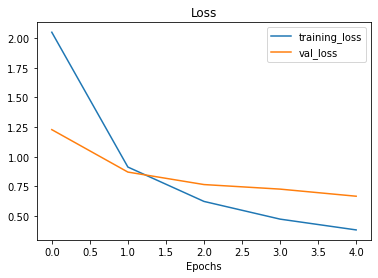

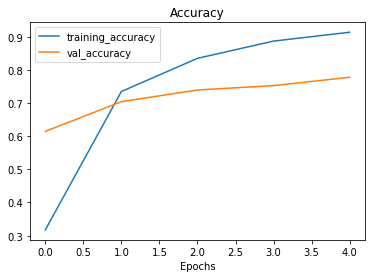

In [13]:
plot_loss_curves(resnet_history)

In [14]:
# EfficientNetB0 model 
efficientnet_model = create_model(model_url=efficientnet_url, # use EfficientNetB0 TensorFlow Hub URL
                                  num_classes=train_data_10_percent.num_classes)

efficientnet_model.compile(loss='categorical_crossentropy',
                           optimizer=tf.keras.optimizers.Adam(),
                           metrics=['accuracy'])

efficientnet_history = efficientnet_model.fit(train_data_10_percent, # only use 10% of training data
                                              epochs=5, # train for 5 epochs
                                              steps_per_epoch=len(train_data_10_percent),
                                              validation_data=test_data,
                                              validation_steps=len(test_data),
                                              callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub", 
                                                                experiment_name="efficientnetB0")])

Saving TensorBoard log files to: tensorflow_hub/efficientnetB0/20220511-194139
Epoch 1/5
24/24 [==============================] - 126s 5s/step - loss: 1.9491 - accuracy: 0.3720 - val_loss: 1.3517 - val_accuracy: 0.7216
Epoch 2/5
24/24 [==============================] - 113s 5s/step - loss: 1.1011 - accuracy: 0.7800 - val_loss: 0.8926 - val_accuracy: 0.8216
Epoch 3/5
24/24 [==============================] - 113s 5s/step - loss: 0.7767 - accuracy: 0.8440 - val_loss: 0.7107 - val_accuracy: 0.8428
Epoch 4/5
24/24 [==============================] - 112s 5s/step - loss: 0.6193 - accuracy: 0.8707 - val_loss: 0.6199 - val_accuracy: 0.8544
Epoch 5/5
24/24 [==============================] - 119s 5s/step - loss: 0.5228 - accuracy: 0.8880 - val_loss: 0.5664 - val_accuracy: 0.8608


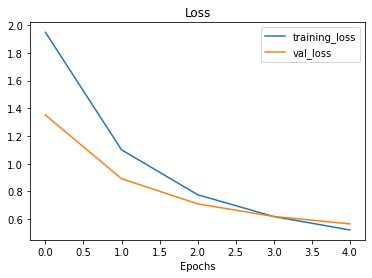

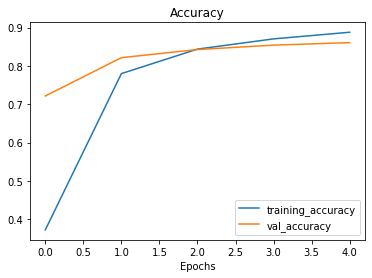

In [15]:
plot_loss_curves(efficientnet_history)